### ImagesClassificationWithSIFT with zca_whitening_parameter to False and featurewise_std_normalization_parameter to False

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv
print("OpenCV Version : "+cv.__version__)
from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
import catboost
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier
# from utils import plot_confusion_matrix

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.0.5
Seaborn Version :0.10.1
OpenCV Version : 3.4.2
Sklearn Version : 0.23.1
Catboost Version : 0.24


Using TensorFlow backend.


Keras Version : 2.2.4-tf
Tensorflow Version : 2.1.0


In [2]:
images_directory = './images/Images/'
# train_contents = sio.loadmat('./lists/train_list.mat')
# test_contents = sio.loadmat('./lists/test_list.mat')
# file_list = sio.loadmat('./lists/file_list.mat')
train_directory = './images/train/'
test_directory = './images/test/'

### Rename the folder names

In [ ]:
def convert(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [ ]:
for root, dirs, files in os.walk(images_directory):
    for count in dirs:
        print(convert(count.split('-')[1].capitalize()))
        os.rename(os.path.join(images_directory, count), os.path.join(images_directory, convert(count.split('-')[1].capitalize())))


### Creation of the  train test directory

In [ ]:
train_dir = './images/train/'
test_dir = './images/test/'


In [ ]:
files = [file for file in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, file))]

In [ ]:
directories = [directory for directory in os.listdir(images_directory)]

In [ ]:
directories

In [ ]:
for directory in directories:
    os.mkdir(train_dir+directory)
    os.mkdir(test_dir+directory)

### Split train test

In [ ]:
directories

In [ ]:
for directory in directories:
    files = [file for file in os.listdir(images_directory+directory) if os.path.isfile(os.path.join(images_directory+directory, file))]
    train_count  = np.round(70/100*len(files))
    test_count = np.round(30/100*len(files))
    rndnums = list(random.sample(range(0, len(files)), len(files)))
    print("len(files)",len(files))
    train_file_index = rndnums[0:int(train_count)+1]
    train_file_name = [files[i] for i in train_file_index]
    test_file_index = rndnums[int(train_count)+1:int(train_count + test_count)+1]
    test_file_name = [files[i] for i in test_file_index]
    for x in train_file_name:
        file = x
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(train_directory+directory, file))
    ##test_files
    for y in test_file_name:
        file = y
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(test_directory+directory, file))

    

In [ ]:
train_file_name

In [3]:
input_directory='./images/'
output_directory='./new_images/'
small_directory_names = [directory for directory in os.listdir(input_directory+'train-small')]
small_directory_names.sort()
zca_whitening_parameter=False
featurewise_std_normalization_parameter=False
color_mode_parameter='grayscale'
save_prefix_parameter='set1_'
batch_size=2
follow_links=True
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zca_whitening=zca_whitening_parameter,
        featurewise_std_normalization=featurewise_std_normalization_parameter
        )

In [4]:
small_directory_names

['Basset', 'Cardigan', 'OldEnglishSheepdog']

In [5]:
myCategories = dict(enumerate(small_directory_names))

In [ ]:
myCategories

In [6]:
train_generator = train_datagen.flow_from_directory(input_directory+'train-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter)

Found 350 images belonging to 3 classes.


In [7]:
test_generator = train_datagen.flow_from_directory(input_directory+'test-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, shuffle=False, color_mode=color_mode_parameter)

Found 148 images belonging to 3 classes.


In [8]:
train_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

In [9]:
test_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

### Compute the descriptors  and add them with the category into a dataframe

In [10]:
algo_constructor = cv.xfeatures2d.SIFT_create()
def computeDescriptors(mygenerator, mydf, mydescriptors):
    count = 0
    for i in range(len(mygenerator)):
    #next(train_generator)
        for j in range(batch_size):
            img = mygenerator[i][0][j].squeeze()
            imgwithrgb = cv.merge([img, img, img])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': mygenerator[i][1][j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            count = count + 1
            j = j+1
    i = i+1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

### Train 

In [11]:
train_descriptors_array=[]
train_df, train_descriptors_array=computeDescriptors(train_generator, train_df, train_descriptors_array)

In [ ]:
plt.imshow(train_df['Picture'][0])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(60, 12))
axs[0].set_title('An Original Picture in grayscale  ', fontsize=20)
axs[0].imshow(train_df['Picture'][0], cmap='Greys_r')
axs[1].set_title('Histogram of an original Picture in grayscale ', fontsize=20)
axs[1].set_xlabel('Level of gray', fontsize=20)
axs[1].set_ylabel('Number of pixels', fontsize=20)
axs[1].hist(train_df['Picture'][0].ravel(), 256, [0, 256])


### Test

In [12]:
test_descriptors_array=[]
test_df, test_descriptors_array=computeDescriptors(test_generator, test_df, test_descriptors_array)

In [ ]:
print(train_df['NumberOfDescriptors'].sum())

In [ ]:
print(test_df['NumberOfDescriptors'].sum())

### Apply a Kmeans to get clusters

In [13]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    # kmeans = KMeans(n_clusters=k, n_init=10)
    mymodel = MiniBatchKMeans(n_clusters=k, n_init=10)
    mymodel.fit(descriptor_list)
    visual_words = mymodel.cluster_centers_
    labels = mymodel.labels_
    silhouette_score = metrics.silhouette_score(descriptor_list, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(descriptor_list, labels)
    print('silhouette_score '+str(silhouette_score))
    print('calinski_harabasz_score '+str(calinski_harabasz_score))
    return mymodel, visual_words, labels
# Takes the central points which is visual words
model, visual_words, labels = kmeans(150, train_descriptors_array)

silhouette_score 0.027864117
calinski_harabasz_score 558.9943689561991


In [14]:
X_train = pd.DataFrame(columns=range(len(visual_words)))
X_test = pd.DataFrame(columns=range(len(visual_words)))

In [15]:
for index, row in train_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)

In [16]:
X_train.fillna(0, inplace=True)

In [ ]:
X_train

In [ ]:
train_df

In [17]:
for index, row in test_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

In [18]:
X_test.fillna(0, inplace=True)

In [ ]:
X_test

In [19]:
le = LabelEncoder().fit(train_df['Category'])

In [20]:
y_train = le.transform(train_df['Category'])
y_test = le.transform(test_df['Category'])

In [ ]:
y_test

### TSNE

In [21]:
X_train_embedded = TSNE(n_components=2).fit_transform(X_train)
X_train_embedded_df = pd.DataFrame(X_train_embedded, columns=['SIFT1', 'SIFT2'])

In [22]:
X_train_embedded_df['Category'] = train_df['Category']

silhouette_score -0.022136096
calinski_harabasz_score 4.00152559419228


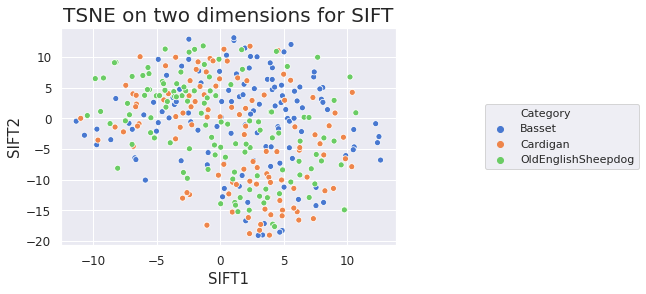

In [24]:
sns.set(palette='muted', color_codes=True, style='darkgrid')
ax = sns.scatterplot(x='SIFT1', y='SIFT2', hue="Category", data=X_train_embedded_df)
ax.set_title('TSNE on two dimensions for SIFT', fontsize=20)
ax.set_xlabel('SIFT1', fontsize=15)
ax.set_ylabel('SIFT2', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.tick_params(labelsize=12)
silhouette_score = metrics.silhouette_score(X_train_embedded, train_df['Category'])
calinski_harabasz_score = metrics.calinski_harabasz_score(X_train_embedded, train_df['Category'])
print('silhouette_score '+str(silhouette_score))
print('calinski_harabasz_score '+str(calinski_harabasz_score))

### CatBoostClassifier 

In [25]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

In [26]:
type(small_directory_names)

list

In [27]:
clf.fit(
    X_train, y_train
    # cat_features=[0, 1, 2]
)

0:	learn: 1.0853698	total: 61.3ms	remaining: 1m 1s
1:	learn: 1.0757225	total: 63.8ms	remaining: 31.8s
2:	learn: 1.0573175	total: 66.6ms	remaining: 22.1s
3:	learn: 1.0409774	total: 69.4ms	remaining: 17.3s
4:	learn: 1.0281913	total: 72.9ms	remaining: 14.5s
5:	learn: 1.0187755	total: 75.9ms	remaining: 12.6s
6:	learn: 1.0052110	total: 79ms	remaining: 11.2s
7:	learn: 0.9943708	total: 81.6ms	remaining: 10.1s
8:	learn: 0.9830563	total: 84.4ms	remaining: 9.29s
9:	learn: 0.9675915	total: 87ms	remaining: 8.61s
10:	learn: 0.9566860	total: 89.9ms	remaining: 8.08s
11:	learn: 0.9414432	total: 92.6ms	remaining: 7.62s
12:	learn: 0.9302543	total: 95.2ms	remaining: 7.23s
13:	learn: 0.9187098	total: 98ms	remaining: 6.9s
14:	learn: 0.9085170	total: 101ms	remaining: 6.61s
15:	learn: 0.8988311	total: 103ms	remaining: 6.36s
16:	learn: 0.8878034	total: 106ms	remaining: 6.14s
17:	learn: 0.8748059	total: 109ms	remaining: 5.94s
18:	learn: 0.8671076	total: 112ms	remaining: 5.77s
19:	learn: 0.8596519	total: 115ms	

183:	learn: 0.1710790	total: 854ms	remaining: 3.79s
184:	learn: 0.1697490	total: 868ms	remaining: 3.83s
185:	learn: 0.1682661	total: 877ms	remaining: 3.84s
186:	learn: 0.1668125	total: 897ms	remaining: 3.9s
187:	learn: 0.1656996	total: 903ms	remaining: 3.9s
188:	learn: 0.1644158	total: 908ms	remaining: 3.9s
189:	learn: 0.1633790	total: 916ms	remaining: 3.9s
190:	learn: 0.1622833	total: 925ms	remaining: 3.92s
191:	learn: 0.1610356	total: 931ms	remaining: 3.92s
192:	learn: 0.1598472	total: 939ms	remaining: 3.92s
193:	learn: 0.1585619	total: 961ms	remaining: 3.99s
194:	learn: 0.1578339	total: 963ms	remaining: 3.97s
195:	learn: 0.1568436	total: 965ms	remaining: 3.96s
196:	learn: 0.1556329	total: 967ms	remaining: 3.94s
197:	learn: 0.1547880	total: 970ms	remaining: 3.93s
198:	learn: 0.1536386	total: 972ms	remaining: 3.91s
199:	learn: 0.1525462	total: 976ms	remaining: 3.9s
200:	learn: 0.1514748	total: 979ms	remaining: 3.89s
201:	learn: 0.1502625	total: 983ms	remaining: 3.88s
202:	learn: 0.149

351:	learn: 0.0683238	total: 1.65s	remaining: 3.03s
352:	learn: 0.0679773	total: 1.65s	remaining: 3.02s
353:	learn: 0.0677271	total: 1.65s	remaining: 3.02s
354:	learn: 0.0674841	total: 1.66s	remaining: 3.01s
355:	learn: 0.0673004	total: 1.66s	remaining: 3s
356:	learn: 0.0669888	total: 1.67s	remaining: 3s
357:	learn: 0.0666940	total: 1.67s	remaining: 3s
358:	learn: 0.0664062	total: 1.67s	remaining: 2.99s
359:	learn: 0.0661200	total: 1.68s	remaining: 2.98s
360:	learn: 0.0658770	total: 1.68s	remaining: 2.98s
361:	learn: 0.0655974	total: 1.69s	remaining: 2.97s
362:	learn: 0.0652806	total: 1.69s	remaining: 2.97s
363:	learn: 0.0650899	total: 1.7s	remaining: 2.96s
364:	learn: 0.0648150	total: 1.72s	remaining: 2.99s
365:	learn: 0.0646113	total: 1.73s	remaining: 3s
366:	learn: 0.0643200	total: 1.73s	remaining: 2.99s
367:	learn: 0.0640658	total: 1.74s	remaining: 2.98s
368:	learn: 0.0638123	total: 1.74s	remaining: 2.98s
369:	learn: 0.0635546	total: 1.75s	remaining: 2.97s
370:	learn: 0.0633039	tot

561:	learn: 0.0348327	total: 2.42s	remaining: 1.88s
562:	learn: 0.0347492	total: 2.42s	remaining: 1.88s
563:	learn: 0.0346337	total: 2.43s	remaining: 1.88s
564:	learn: 0.0345414	total: 2.43s	remaining: 1.87s
565:	learn: 0.0344446	total: 2.44s	remaining: 1.87s
566:	learn: 0.0343300	total: 2.44s	remaining: 1.87s
567:	learn: 0.0342779	total: 2.45s	remaining: 1.86s
568:	learn: 0.0341721	total: 2.46s	remaining: 1.86s
569:	learn: 0.0340969	total: 2.5s	remaining: 1.88s
570:	learn: 0.0340280	total: 2.5s	remaining: 1.88s
571:	learn: 0.0339456	total: 2.54s	remaining: 1.9s
572:	learn: 0.0338866	total: 2.54s	remaining: 1.9s
573:	learn: 0.0338214	total: 2.56s	remaining: 1.9s
574:	learn: 0.0337503	total: 2.56s	remaining: 1.9s
575:	learn: 0.0336668	total: 2.57s	remaining: 1.89s
576:	learn: 0.0335831	total: 2.58s	remaining: 1.89s
577:	learn: 0.0335016	total: 2.58s	remaining: 1.88s
578:	learn: 0.0334319	total: 2.59s	remaining: 1.88s
579:	learn: 0.0333536	total: 2.59s	remaining: 1.88s
580:	learn: 0.0332

764:	learn: 0.0229645	total: 3.6s	remaining: 1.1s
765:	learn: 0.0229139	total: 3.62s	remaining: 1.11s
766:	learn: 0.0228707	total: 3.63s	remaining: 1.1s
767:	learn: 0.0228343	total: 3.63s	remaining: 1.1s
768:	learn: 0.0227927	total: 3.63s	remaining: 1.09s
769:	learn: 0.0227526	total: 3.64s	remaining: 1.09s
770:	learn: 0.0227041	total: 3.65s	remaining: 1.08s
771:	learn: 0.0226556	total: 3.65s	remaining: 1.08s
772:	learn: 0.0226224	total: 3.65s	remaining: 1.07s
773:	learn: 0.0225868	total: 3.66s	remaining: 1.07s
774:	learn: 0.0225574	total: 3.66s	remaining: 1.06s
775:	learn: 0.0225132	total: 3.67s	remaining: 1.06s
776:	learn: 0.0224722	total: 3.67s	remaining: 1.05s
777:	learn: 0.0224542	total: 3.67s	remaining: 1.05s
778:	learn: 0.0224220	total: 3.67s	remaining: 1.04s
779:	learn: 0.0223793	total: 3.67s	remaining: 1.04s
780:	learn: 0.0223502	total: 3.68s	remaining: 1.03s
781:	learn: 0.0223098	total: 3.68s	remaining: 1.02s
782:	learn: 0.0222745	total: 3.68s	remaining: 1.02s
783:	learn: 0.02

944:	learn: 0.0174627	total: 4.18s	remaining: 243ms
945:	learn: 0.0174417	total: 4.18s	remaining: 239ms
946:	learn: 0.0174182	total: 4.18s	remaining: 234ms
947:	learn: 0.0173973	total: 4.19s	remaining: 230ms
948:	learn: 0.0173777	total: 4.19s	remaining: 225ms
949:	learn: 0.0173550	total: 4.19s	remaining: 221ms
950:	learn: 0.0173279	total: 4.2s	remaining: 217ms
951:	learn: 0.0173055	total: 4.21s	remaining: 212ms
952:	learn: 0.0172809	total: 4.21s	remaining: 208ms
953:	learn: 0.0172484	total: 4.21s	remaining: 203ms
954:	learn: 0.0172284	total: 4.22s	remaining: 199ms
955:	learn: 0.0171998	total: 4.22s	remaining: 194ms
956:	learn: 0.0171760	total: 4.23s	remaining: 190ms
957:	learn: 0.0171563	total: 4.23s	remaining: 185ms
958:	learn: 0.0171380	total: 4.25s	remaining: 181ms
959:	learn: 0.0171171	total: 4.25s	remaining: 177ms
960:	learn: 0.0170938	total: 4.25s	remaining: 172ms
961:	learn: 0.0170714	total: 4.25s	remaining: 168ms
962:	learn: 0.0170506	total: 4.25s	remaining: 163ms
963:	learn: 0

In [28]:
y_pred = clf.predict(data=X_test)

### Results

----- Accuracy: 56.76 % -----


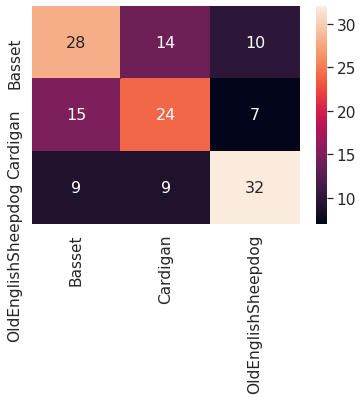

In [29]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), small_directory_names, small_directory_names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()